In [1]:
import pandas as pd
from random import seed
import random as rm
import itertools
import pyemma

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import mdshare  # for trajectory data

from tqdm.notebook import tqdm  # progress bar
import seaborn as sns  # for plotting

In [3]:
import deeptime
deeptime.__version__

'0.4.4'

In [4]:
class Dimer(object):
    def __init__(self, index):
        self.index = index
        self._trajectory_states = []
        self._state = self.states[0]
    
    def state_to_features(self):
        if self._state == "CC":
            return np.asarray([0.9, 0.1, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "OC":
            return np.asarray([0.1, 0.9, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "CO":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "OO":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "CD":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.4, 0.6])
        elif self._state == "OD":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.4, 0.6])
        elif self._state == "DC":
            return np.asarray([0.1, 0.4, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "DO":
            return np.asarray([0.1, 0.4, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "DD":
            return np.asarray([0.1, 0.4, 0.6, 0.1, 0.4, 0.6])
            
        
    def run(self, step):
        self._trajectory = np.zeros([step, 6])
        
        # Init state CC
        self._state = self.states[0]
        self._trajectory_states.append(self.state) 
        self._trajectory[0] = self.state_to_features()
        
        for i in range(1, step):
            if i % 5 == 0:
                self.propagate()
                
            self._trajectory_states.append(self.state) 
            self._trajectory[i] = self.state_to_features()

            
        noise = np.random.normal(0, .01, self._trajectory.shape)
        self._trajectory = self._trajectory + noise
        
    @property
    def state(self):
        return self._state
    
    @property
    def trajectory(self):
        return self._trajectory
    
    @property
    def trajectory_states(self):
        return self._trajectory_states
    
    def propagate(self):
        state_ind = self.states.index(self.state)
        transition = np.random.choice(self.transitionName[state_ind],
                                      replace=True,
                                      p=self.transitionMatrix[state_ind])
        self._state = transition.split('_')[1]
        
    # The statespace
    states = ["CC","OC","CO", "OO", "CD", "OD", "DC", "DO", "DD"]
    
    single_states = ["C", "O", "D"]


    # Possible sequences of events
    transitionName = [["CC_CC", "CC_OC", "CC_CO", "CC_OO", "CC_CD", "CC_OD", "CC_DC", "CC_DO", "CC_DD"],
                      ["OC_CC", "OC_OC", "OC_CO", "OC_OO", "OC_CD", "OC_OD", "OC_DC", "OC_DO", "OC_DD"],
                      ["CO_CC", "CO_OC", "CO_CO", "CO_OO", "CO_CD", "CO_OD", "CO_DC", "CO_DO", "CO_DD"],
                      ["OO_CC", "OO_OC", "OO_CO", "OO_OO", "OO_CD", "OO_OD", "OO_DC", "OO_DO", "OO_DD"],
                      ["CD_CC", "CD_OC", "CD_CO", "CD_OO", "CD_CD", "CD_OD", "CD_DC", "CD_DO", "CD_DD"],
                      ["OD_CC", "OD_OC", "OD_CO", "OD_OO", "OD_CD", "OD_OD", "OD_DC", "OD_DO", "OD_DD"],
                      ["DC_CC", "DC_OC", "DC_CO", "DC_OO", "DC_CD", "DC_OD", "DC_DC", "DC_DO", "DC_DD"],
                      ["DO_CC", "DO_OC", "DO_CO", "DO_OO", "DO_CD", "DO_OD", "DO_DC", "DO_DO", "DO_DD"],
                      ["DD_CC", "DD_OC", "DD_CO", "DD_OO", "DD_CD", "DD_OD", "DD_DC", "DD_DO", "DD_DD"],
                     ]

    # Probabilities matrix (transition matrix)
    transitionMatrix = [[0.6, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  #CC
                        [0.1, 0.3, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0],  #OC
                        [0.1, 0.0, 0.3, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0],  #CO
                        [0.0, 0.1, 0.1, 0.4, 0.0, 0.2, 0.0, 0.2, 0.0],  #OO
                        [0.2, 0.0, 0.1, 0.0, 0.2, 0.1, 0.0, 0.0, 0.4],  #CD
                        [0.0, 0.3, 0.0, 0.1, 0.2, 0.2, 0.0, 0.0, 0.2],  #OD
                        [0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.2, 0.1, 0.4],  #DC
                        [0.0, 0.0, 0.3, 0.1, 0.0, 0.0, 0.2, 0.2, 0.2],  #DO
                        [0.0, 0.0, 0.0, 0.0, 0.15, 0.1, 0.15, 0.1, 0.5] #DD
                       ]

In [5]:
glic_dimer = Dimer(0)

In [6]:
glic_dimer.run(10000)

In [7]:
from typing import Optional, List
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

class MultimerTrajectoriesDataset(TrajectoriesDataset):
    def __init__(self, multimer: int, data: List[TrajectoryDataset]):
        self.multimer = multimer
        super().__init__(data)

    @staticmethod
    def from_numpy(lagtime, multimer, data: List[np.ndarray]):
        assert isinstance(data, list)
        assert len(data) > 0 and all(data[0].shape[1:] == x.shape[1:] for x in data), "Shape mismatch!"

        data_new = []
        total_shape = data[0].shape[1]
        per_shape = int(total_shape / multimer)

        for i in range(multimer):
            data_new.extend(
                [np.roll(traj.reshape(traj.shape[0], multimer, per_shape),
                                                i, axis=1).reshape(traj.shape[0],total_shape)
                for traj in data])
        return MultimerTrajectoriesDataset(multimer, [TrajectoryDataset(lagtime, traj) for traj in data_new])

In [33]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

data = [glic_dimer.trajectory.astype(np.float32)]
dataset = MultimerTrajectoriesDataset.from_numpy(5, 2, data)

In [34]:
from scipy.fft import fft, ifft

In [11]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

data = [glic_dimer.trajectory.astype(np.float32)]
dataset = MultimerTrajectoriesDataset.from_numpy(5, 3, [np.real(fft(data)[0])])

In [35]:
from deeptime.decomposition import TICA

tica = TICA(var_cutoff=None, lagtime=5)

tica.fit(dataset)

tica_output= tica.transform(dataset)
tica_concatenated= np.concatenate(tica_output)

tica_model_tica = tica.fetch_model()

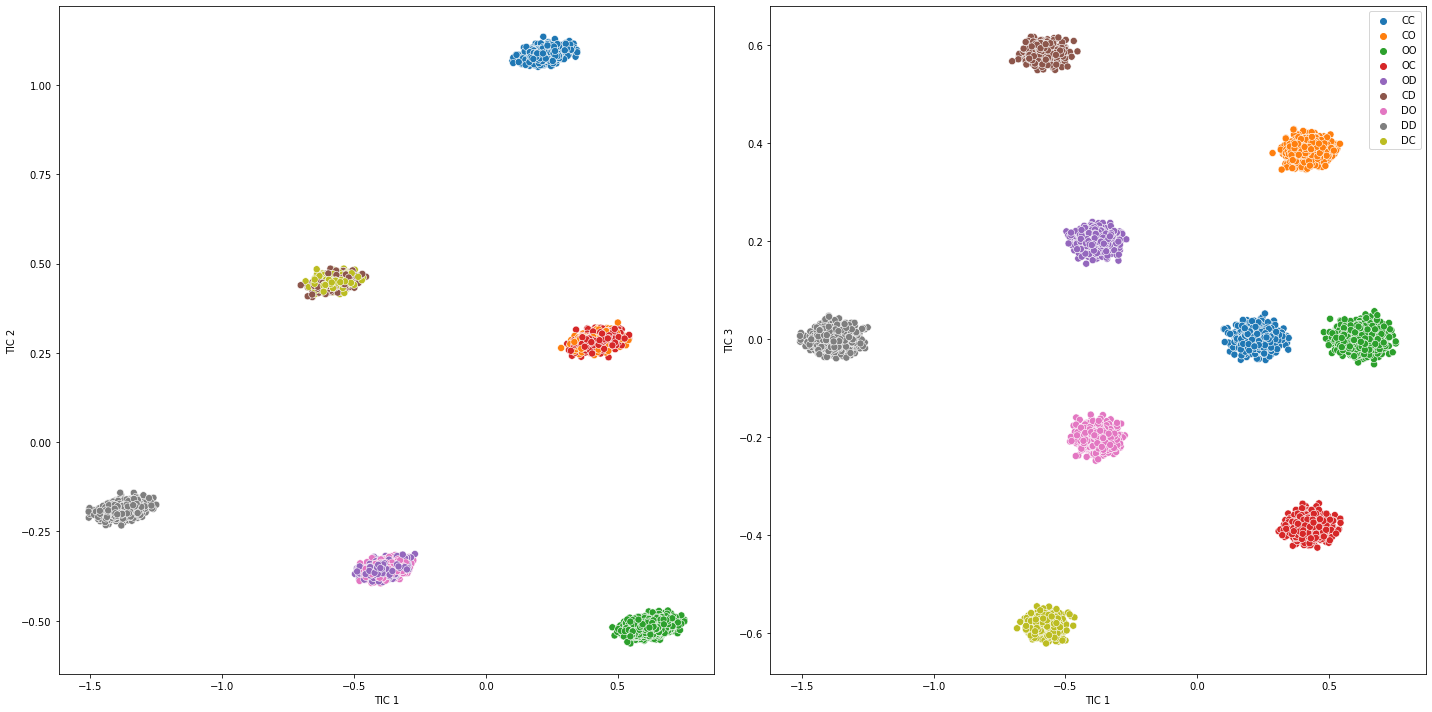

In [36]:
feature = dataset.trajectories[0]
feature_transformed = tica.transform(feature)
fig, axes = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(
            x=feature_transformed[:, 0],
            y=feature_transformed[:, 1],
            hue=glic_dimer.trajectory_states,
            s=50, alpha=1, ax=axes[0], legend=False)

axes[0].set_xlabel("TIC 1")
axes[0].set_ylabel("TIC 2")
sns.scatterplot(
            x=feature_transformed[:, 0],
            y=feature_transformed[:, 3],
            hue=glic_dimer.trajectory_states,
            s=50, alpha=1, ax=axes[1])

axes[1].set_xlabel("TIC 1")
axes[1].set_ylabel("TIC 3")
plt.legend(loc='upper right')
plt.tight_layout()

<AxesSubplot: >

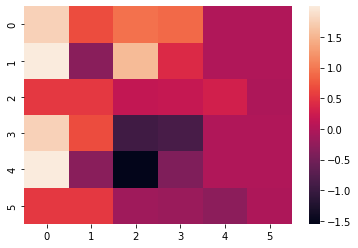

In [37]:
sns.heatmap(tica_model_tica.instantaneous_coefficients)

In [38]:
tica_model_tica.timescales(k=n_timescales)

array([12.4212826 ,  7.61962267,  5.5075165 ,  3.7728897 ,  0.91160047,
        0.62716147])

Text(0.5, 0, 'Timescale index')

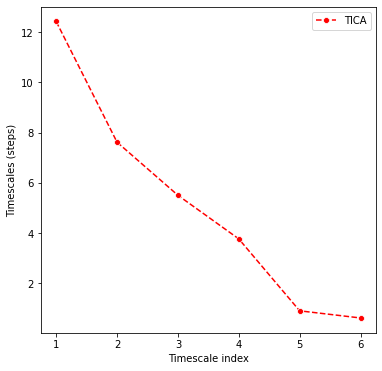

In [39]:
fig, ax = plt.subplots(figsize=(6,6))
n_timescales=100
sns.lineplot(x=np.arange(1, tica_model_tica.timescales(k=n_timescales).shape[0]+1),
             y=tica_model_tica.timescales(k=n_timescales), marker='o', linestyle='--', color='red', label='TICA')
ax.set_ylabel('Timescales (steps)')
ax.set_xlabel('Timescale index')

In [40]:
from msm_a7_nachrs.tica.sym_tica import SymTICA

symtica = SymTICA(symmetry_fold=2, var_cutoff=0.8, lagtime=5, scaling=None)

symtica.fit(dataset)

symtica_output= symtica.transform(dataset.trajectories[0])
#symtica_output= symtica.transform([glic_trimer.trajectory.reshape(glic_trimer.trajectory.shape[0], 3, -1).mean(axis=2)])
symtica_concatenated= np.concatenate(symtica_output)

symmetry_fold 2


In [41]:
symtica_model_tica = symtica.fetch_model()

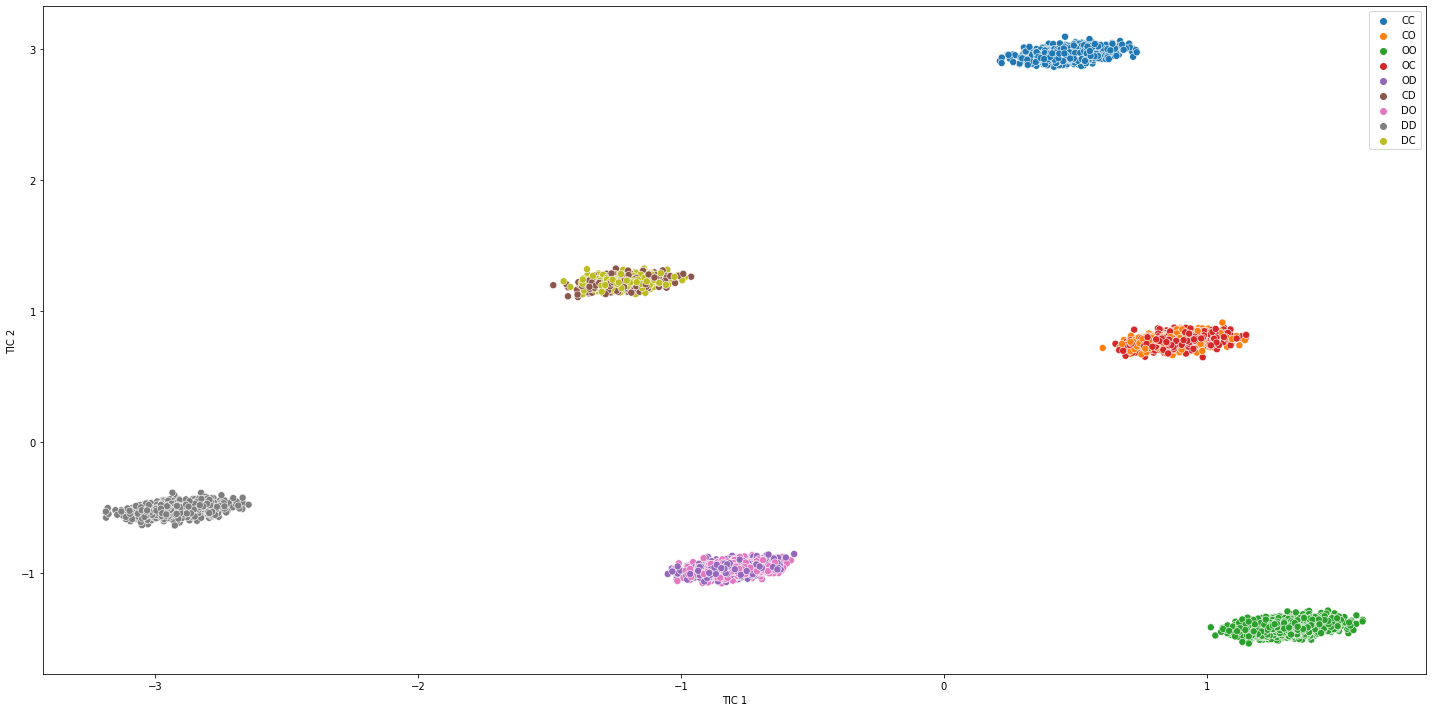

In [42]:
feature = dataset.trajectories[0]
feature_transformed = np.real(symtica.transform(feature))
fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.scatterplot(
            x=feature_transformed[:, 0],
            y=feature_transformed[:, 1],
            hue=glic_dimer.trajectory_states,
            s=50, alpha=1, ax=ax, legend=True)

ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
plt.legend(loc='upper right')
plt.tight_layout()

Text(0.5, 0, 'Timescale index')

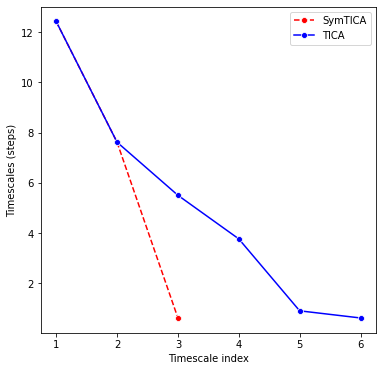

In [43]:
fig, ax = plt.subplots(figsize=(6,6))
n_timescales=100
sns.lineplot(x=np.arange(1, symtica_model_tica.timescales(k=n_timescales).shape[0]+1),
             y=symtica_model_tica.timescales(k=n_timescales), marker='o', linestyle='--', color='red', label='SymTICA')
sns.lineplot(x=np.arange(1, tica_model_tica.timescales(k=n_timescales).shape[0]+1),
             y=tica_model_tica.timescales(k=n_timescales), marker='o', linestyle='-', color='blue', label='TICA')

ax.set_ylabel('Timescales (steps)')
ax.set_xlabel('Timescale index')

In [ ]:
data_contat = np.concatenate(data)

In [ ]:
glic_trimer.trajectory.shape

data_cut = []
for i in range(3):
    data_cut.append(glic_trimer.trajectory[:, i*3:(i+1)*3])

dataset_cut = TrajectoriesDataset.from_numpy(5, data_cut)

In [ ]:
from deeptime.decomposition import TICA

tica_cut = TICA(var_cutoff=None, lagtime=5)

tica_cut.fit(dataset_cut)

tica_output_cut = tica_cut.transform(dataset_cut)
tica_concatenated_cut = np.concatenate(tica_output_cut)

tica_model_tica_cut = tica_cut.fetch_model()

In [ ]:
states_cut = [stat[0] for stat in glic_trimer.trajectory_states] + \
[stat[1] for stat in glic_trimer.trajectory_states] + \
[stat[2] for stat in glic_trimer.trajectory_states]

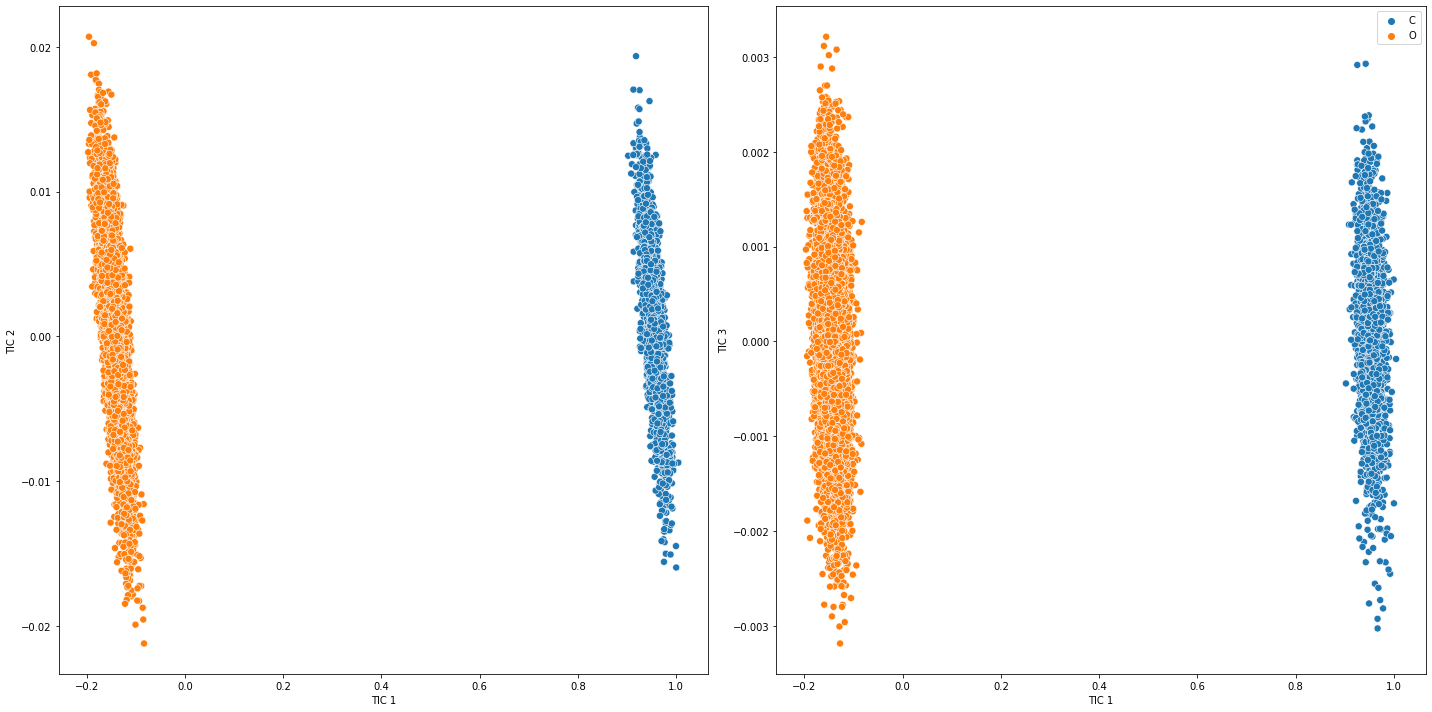

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
tica_out_all = np.concatenate([tica_cut.transform([glic_trimer.trajectory[:, i*3:(i+1)*3]])[0] for i in range(3)])
sns.scatterplot(
            x=tica_out_all[:, 0],
            y=tica_out_all[:, 1],
            hue=states_cut,
            s=50, alpha=1, ax=axes[0], legend=False)

axes[0].set_xlabel("TIC 1")
axes[0].set_ylabel("TIC 2")
sns.scatterplot(
            x=tica_out_all[:, 0],
            y=tica_out_all[:, 2],
            hue=states_cut,
            s=50, alpha=1, ax=axes[1])

axes[1].set_xlabel("TIC 1")
axes[1].set_ylabel("TIC 3")
plt.legend(loc='upper right')
plt.tight_layout()

Text(0.5, 0, 'Timescale index')

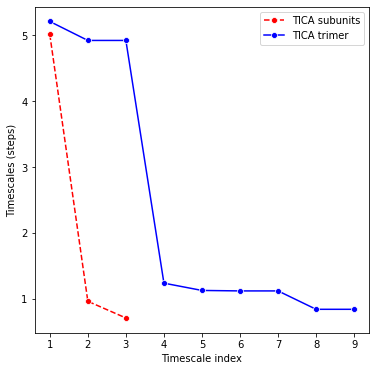

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
n_timescales=100
sns.lineplot(x=np.arange(1, tica_model_tica_cut.timescales(k=n_timescales).shape[0]+1),
             y=tica_model_tica_cut.timescales(k=n_timescales), marker='o', linestyle='--', color='red', label='TICA subunits')
sns.lineplot(x=np.arange(1, tica_model_tica.timescales(k=n_timescales).shape[0]+1),
                y=tica_model_tica.timescales(k=n_timescales), marker='o', linestyle='-', color='blue', label='TICA trimer')
ax.set_ylabel('Timescales (steps)')
ax.set_xlabel('Timescale index')

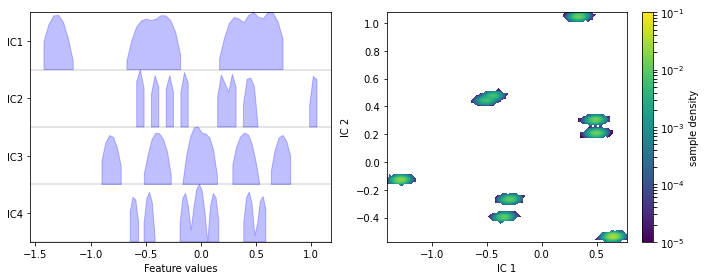

In [178]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', "IC2", "IC3", "IC4"],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

In [179]:
import itertools

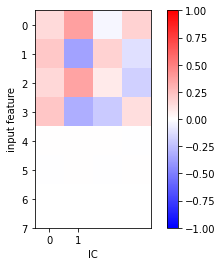

In [180]:
fig, ax = plt.subplots()
i = ax.imshow(np.array(sorted(tica.feature_TIC_correlation[:,:10],
                              key=lambda row: np.abs(row[1]), reverse=True))[:20,:],
              cmap='bwr', vmin=-1, vmax=1)

ax.set_xticks([0, 1])
ax.set_xlabel('IC')
ax.set_yticks(range(8))
#ax.set_yticklabels(feats)
ax.set_ylabel('input feature')

fig.colorbar(i);

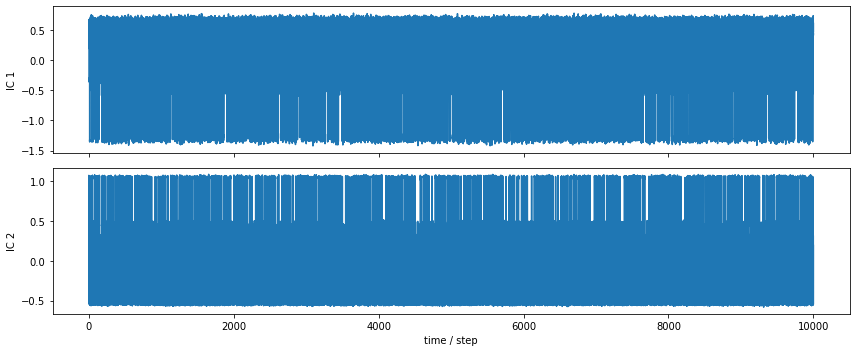

In [181]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / step')
fig.tight_layout()

In [160]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=9, max_iter=50, stride=10, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

initialize kmeans++ centers:   0%|          | 0/9 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

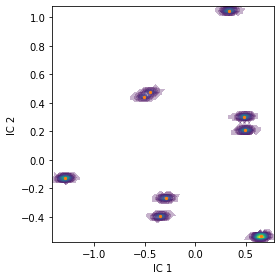

In [161]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

10-06-21 13:18:15 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[259] WARNING  Changed user setting nits to the number of available timescales nits=8


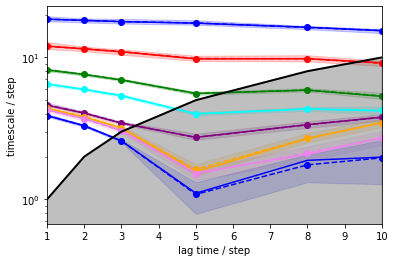

In [162]:
its = pyemma.msm.its(cluster.dtrajs, lags=10, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='step', dt=1);

In [163]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=5, dt_traj='1 step')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[261]: compute stat. inefficiencies:   0%|          | 0/39 [00:0…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[261]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

fraction of states used = 1.00
fraction of counts used = 1.00


estimating BayesianMSM:   0%|          | 0/4 [00:00<?, ?it/s]

/nethome/yzhuang/git_repo/PyEMMA/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


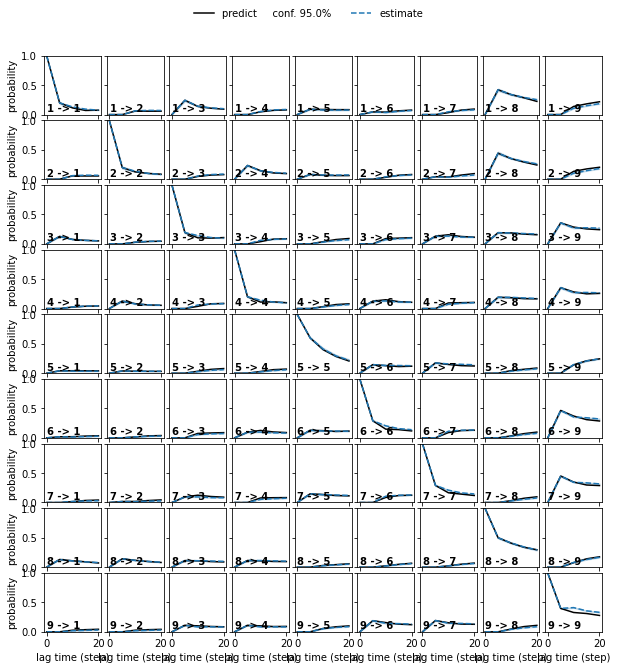

In [164]:
nstates = 9
cktest = msm.cktest(nstates, mlags=range(5))
pyemma.plots.plot_cktest(cktest, dt=1, units='step');

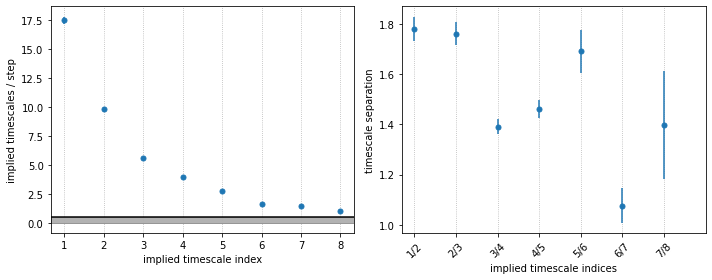

In [165]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 8

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean, 
    yerr=timescales_std, 
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:], 
    yerr=its_separation_err(
        timescales_mean, 
        timescales_std), 
    fmt='.', 
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / step')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 0)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

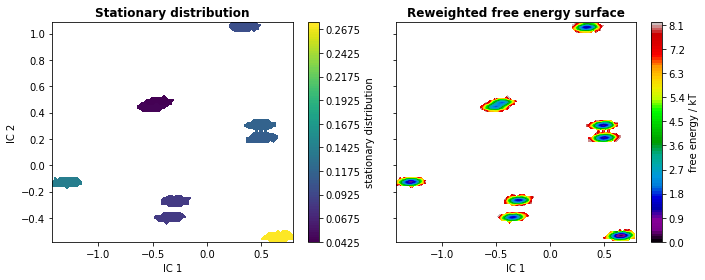

In [166]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

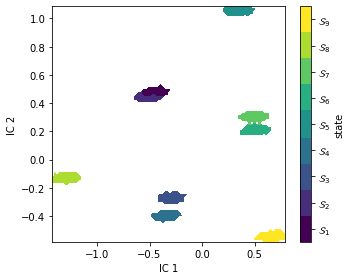

In [167]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()

In [168]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

In [169]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

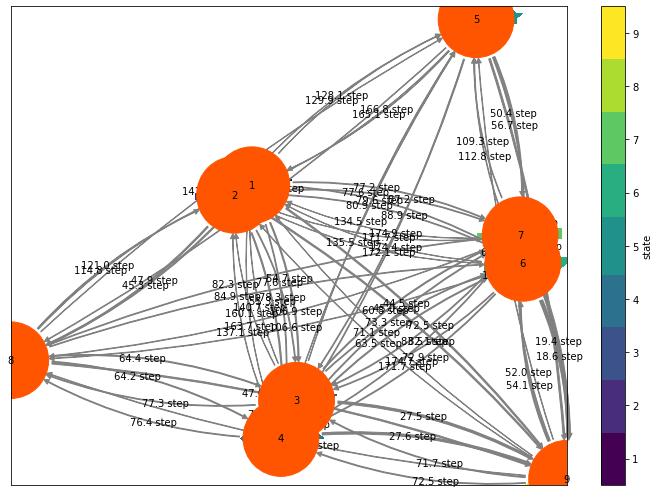

In [170]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.1f step',
    arrow_labels=mfpt,
    size=10,
    show_frame=True,
    state_labels=['1','2','3','4', '5', '6','7','8','9'],
    ax=ax)

fig.tight_layout()

In [172]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / steps:


,1,2,3,4,5,6,7,8,9
1,0.00,143.74,54.68,78.33,128.10,79.60,77.23,47.93,44.52
2,147.29,0.00,77.60,55.26,129.88,80.93,77.56,45.28,45.03
3,140.68,160.06,0.00,79.41,134.46,73.31,60.83,77.33,27.46
4,163.67,137.06,78.75,0.00,135.49,63.46,71.11,76.43,27.61
5,166.83,165.06,87.18,88.87,0.00,56.74,50.39,107.38,36.64
6,174.35,172.13,82.06,72.87,112.76,0.00,61.95,106.57,18.61
7,174.92,171.70,72.51,83.46,109.34,64.89,0.00,106.86,19.44
8,121.01,114.82,64.41,64.17,141.73,84.90,82.25,0.00,46.99
9,174.71,171.68,71.65,72.46,128.11,54.05,51.96,104.10,0.00


## Subunit

In [203]:
glic_dimer.trajectory

array([[0.90068154, 0.1041162 , 0.60413107, 0.89798534, 0.08987536,
        0.59931054],
       [0.91375792, 0.08888404, 0.6152215 , 0.90238873, 0.08994982,
        0.60726854],
       [0.89541847, 0.11215663, 0.60685348, 0.89844615, 0.09582687,
        0.60219973],
       ...,
       [0.10232318, 0.8908396 , 0.61089314, 0.89877691, 0.10214396,
        0.60265678],
       [0.10494212, 0.89708178, 0.59789879, 0.89114141, 0.11030093,
        0.57938139],
       [0.08647941, 0.88725339, 0.59331997, 0.88297722, 0.1109838 ,
        0.60251908]])

In [204]:
tica = pyemma.coordinates.tica([glic_dimer.trajectory.T[:3].T, glic_dimer.trajectory.T[3:].T], lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

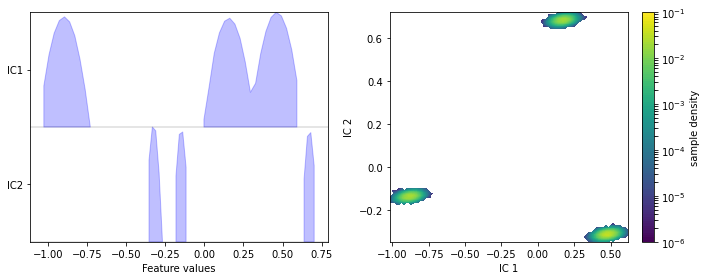

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

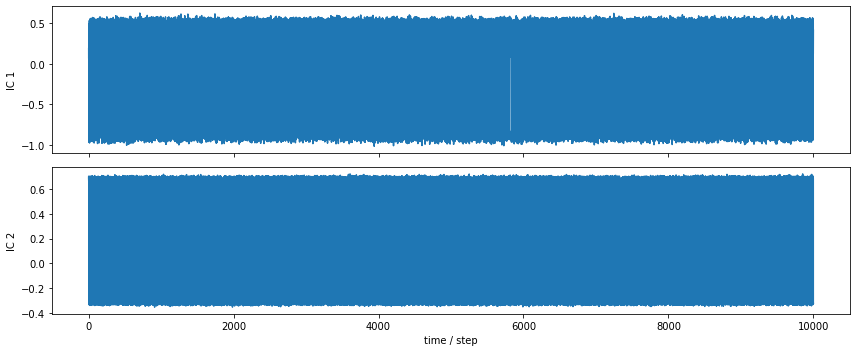

In [206]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / step')
fig.tight_layout()

In [207]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=3, max_iter=50, stride=10, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

initialize kmeans++ centers:   0%|          | 0/3 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

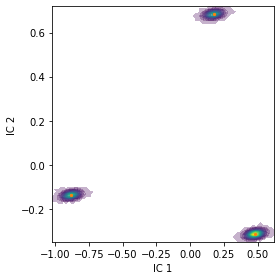

In [208]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

10-06-21 13:25:51 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[272] WARNING  Changed user setting nits to the number of available timescales nits=2


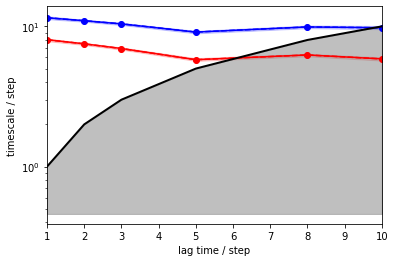

In [209]:
its = pyemma.msm.its(cluster.dtrajs, lags=10, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='step', dt=1);

In [210]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=5, dt_traj='1 step')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[274]: compute stat. inefficiencies:   0%|          | 0/9 [00:00…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[274]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

fraction of states used = 1.00
fraction of counts used = 1.00


estimating BayesianMSM:   0%|          | 0/4 [00:00<?, ?it/s]

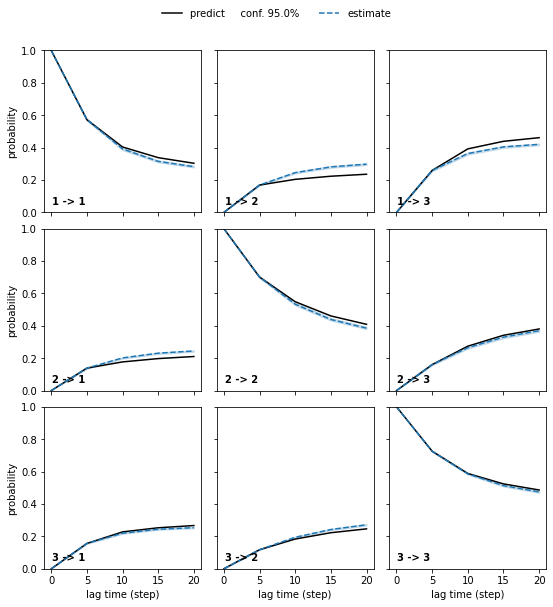

In [211]:
nstates = 3
cktest = msm.cktest(nstates, mlags=range(5))
pyemma.plots.plot_cktest(cktest, dt=1, units='step');

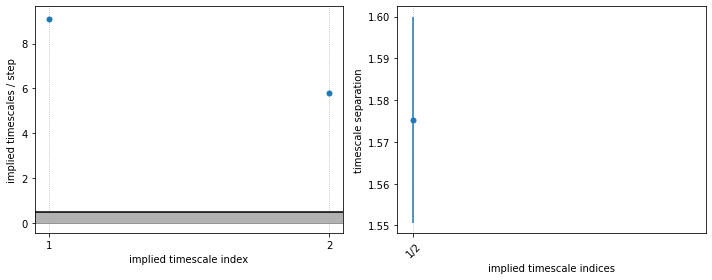

In [212]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 2

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean, 
    yerr=timescales_std, 
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:], 
    yerr=its_separation_err(
        timescales_mean, 
        timescales_std), 
    fmt='.', 
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / step')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 0)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

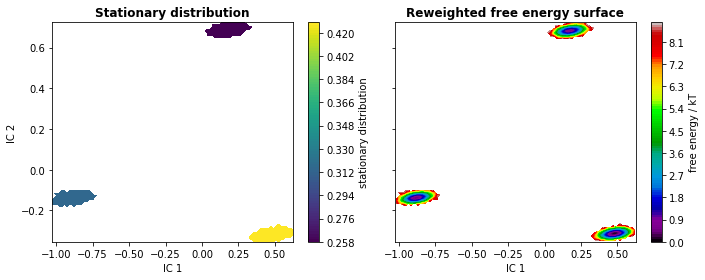

In [213]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

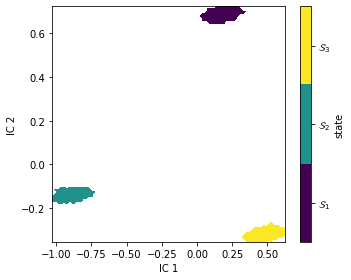

In [214]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()

In [215]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

In [216]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

In [217]:
glic_dimer.trajectory_states[60]

'CO'

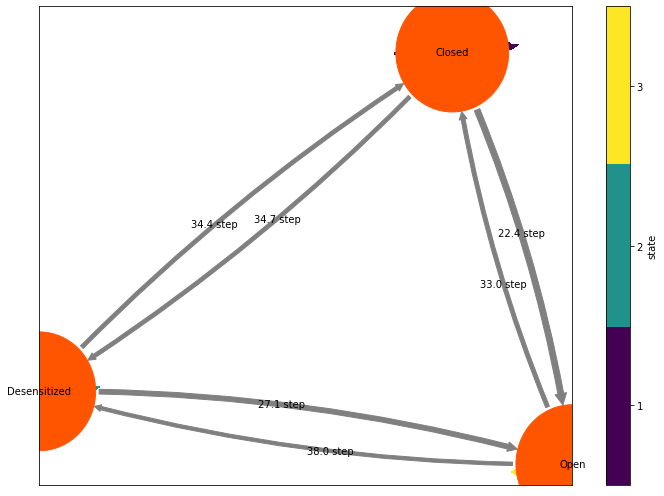

In [218]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.1f step',
    arrow_labels=mfpt,
    size=10,
    show_frame=True,
    state_labels=['Closed','Desensitized','Open'],
    ax=ax)

fig.tight_layout()

In [221]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=2), index=['C', 'D', 'O'], columns=['C', 'D', 'O'])

MFPT / steps:


,C,D,O
C,0.0,34.72,22.37
D,34.4,0.00,27.08
O,33.0,38.03,0.00


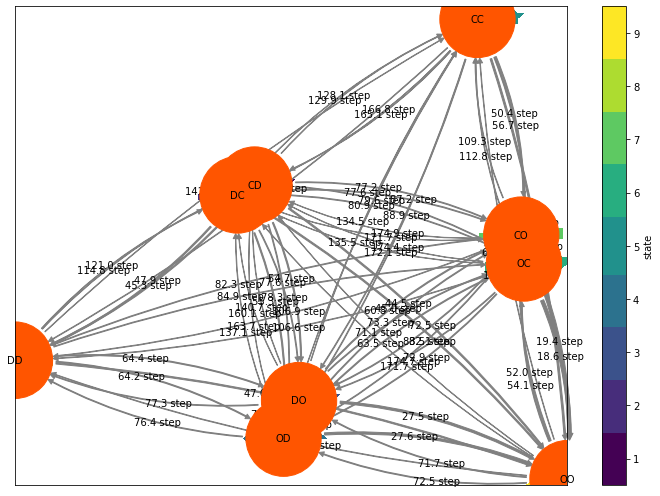

In [201]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.1f step',
    arrow_labels=mfpt,
    size=10,
    show_frame=True,
    state_labels=['CD','DC','DO','OD', 'CC', 'OC','CO','DD','OO'],
    ax=ax)

fig.tight_layout()

In [202]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=2), index=['CD','DC','DO','OD', 'CC', 'OC','CO','DD','OO'], columns=['CD','DC','DO','OD', 'CC', 'OC','CO','DD','OO'])

MFPT / steps:


,CD,DC,DO,OD,CC,OC,CO,DD,OO
CD,0.00,143.74,54.68,78.33,128.10,79.60,77.23,47.93,44.52
DC,147.29,0.00,77.60,55.26,129.88,80.93,77.56,45.28,45.03
DO,140.68,160.06,0.00,79.41,134.46,73.31,60.83,77.33,27.46
OD,163.67,137.06,78.75,0.00,135.49,63.46,71.11,76.43,27.61
CC,166.83,165.06,87.18,88.87,0.00,56.74,50.39,107.38,36.64
OC,174.35,172.13,82.06,72.87,112.76,0.00,61.95,106.57,18.61
CO,174.92,171.70,72.51,83.46,109.34,64.89,0.00,106.86,19.44
DD,121.01,114.82,64.41,64.17,141.73,84.90,82.25,0.00,46.99
OO,174.71,171.68,71.65,72.46,128.11,54.05,51.96,104.10,0.00


In [222]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=2), index=['C', 'D', 'O'], columns=['C', 'D', 'O'])

MFPT / steps:


,C,D,O
C,0.0,34.72,22.37
D,34.4,0.00,27.08
O,33.0,38.03,0.00


In [48]:
class Dimer(object):
    def __init__(self, index):
        self.index = index
#        self._trajectory = []
        self._state = self.states[0]
        
    def run(self, step):
        self._trajectory = np.zeros([step, 4])
        for i in range(step):
            if i % 5 == 0:
                self.propagate()
            self._trajectory[i] = (np.asarray([
                                    self.single_states.index(self.state[0]),
                                    self.single_states.index(self.state[0]),
                                    self.single_states.index(self.state[1]),
                                    self.single_states.index(self.state[1]),
                                    ]))
            
        noise = np.random.normal(0, .1, self._trajectory.shape)
        self._trajectory = self._trajectory + noise
        
    @property
    def state(self):
        return self._state
    
    @property
    def trajectory(self):
        return self._trajectory
    
    
    def propagate(self):
        state_ind = self.states.index(self.state)
        transition = np.random.choice(self.transitionName[state_ind],
                                      replace=True,
                                      p=self.transitionMatrix[state_ind])
        self._state = transition.split('_')[1]
        
    # The statespace
    states = ["CCCC","OCCC","COCC", "CCOC", "CCCO",
              "OOCC", "OCOC", "OCCO","COOC",'COCO',"CCOO",
              "OOOC", "OOCO", "OCOO", "COOO", "OOOO"]
    
    single_states = ["CC","CO","OC", "OO"]


    # Possible sequences of events
    transitionName = [["_".join(stat) for stat in itertools.product([states_iter], states)] for states_iter in states]

    # Probabilities matrix (transition matrix)
    transitionMatrix = [[0.6, 0.2, 0.2, 0.0],
                        [0.1, 0.3, 0.0, 0.6],
                        [0.1, 0.0, 0.3, 0.6],
                        [0.0, 0.1, 0.1, 0.8]]

NameError: name 'states' is not defined